# Style Detection Model for Indonesian Language
## Task 3 : Language Style Classification (Formal vs Informal)

**Course:** IF5153 Natural Language Processing  
**Dataset:** STIF-Indonesia (haryoaw/stif-indonesia)  
**Base Model:** IndoBERTweet

### Objective
To build a model that detects and classifies the language style of Indonesian text into:
- **Formal**: Text that uses standard and formal language  
- **Informal**: Text that uses non-standard language, slang, or conversational style

### Dataset
The STIF-Indonesia dataset contains informal–formal text pairs in Indonesian, collected from the Customer Service domain.


In [ ]:
# Install required libraries
!pip install -q transformers datasets accelerate torch scikit-learn pandas numpy matplotlib seaborn


## 2. Import Libraries


In [ ]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Warning: CUDA not available. Training will be slower on CPU.")

print("Libraries imported successfully!")


Using device: cuda
Libraries imported successfully!


## 3. Load Dataset STIF-Indonesia


In [ ]:
# Load STIF-Indonesia dataset from Hugging Face
print("Loading STIF-Indonesia dataset...")
dataset = load_dataset("haryoaw/stif-indonesia")

print("Dataset loaded successfully!")
print(f"Dataset structure: {dataset}")
print(f"\nDataset splits: {list(dataset.keys())}")

# Display dataset info
for split in dataset.keys():
    print(f"\n{split.upper()} split:")
    print(f"  Number of samples: {len(dataset[split])}")
    print(f"  Features: {list(dataset[split].features.keys())}")


Loading STIF-Indonesia dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

dev.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/214 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/363 [00:00<?, ? examples/s]

Dataset loaded successfully!
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['informal', 'formal'],
        num_rows: 1922
    })
    dev: Dataset({
        features: ['informal', 'formal'],
        num_rows: 214
    })
    test: Dataset({
        features: ['informal', 'formal'],
        num_rows: 363
    })
})

Dataset splits: ['train', 'dev', 'test']

TRAIN split:
  Number of samples: 1922
  Features: ['informal', 'formal']

DEV split:
  Number of samples: 214
  Features: ['informal', 'formal']

TEST split:
  Number of samples: 363
  Features: ['informal', 'formal']


## 4. Eksplorasi Dataset


In [ ]:
# Explore dataset structure and examples
print("=== Dataset Exploration ===\n")

# Show first few examples
print("Sample examples from train split:")
for i in range(min(5, len(dataset['train']))):
    example = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"  Informal: {example['informal']}")
    print(f"  Formal: {example['formal']}")
    print("-" * 80)

# Check data distribution
print(f"\n=== Dataset Statistics ===")
print(f"Train samples: {len(dataset['train'])}")
if 'dev' in dataset:
    print(f"Dev samples: {len(dataset['dev'])}")
if 'test' in dataset:
    print(f"Test samples: {len(dataset['test'])}")

# Check text length statistics
train_informal_lengths = [len(text.split()) for text in dataset['train']['informal']]
train_formal_lengths = [len(text.split()) for text in dataset['train']['formal']]

print(f"\n=== Text Length Statistics ===")
print(f"Informal text - Mean length: {np.mean(train_informal_lengths):.2f} words")
print(f"Informal text - Median length: {np.median(train_informal_lengths):.2f} words")
print(f"Formal text - Mean length: {np.mean(train_formal_lengths):.2f} words")
print(f"Formal text - Median length: {np.median(train_formal_lengths):.2f} words")


=== Dataset Exploration ===

Sample examples from train split:

Example 1:
  Informal: alhamdulillah stlh libur xxxnumberxxx hari onbid lgsg dikasih orderan , food lg . thanks xxxuserxxx cc
  Formal: alhamdulillah setelah libur xxxnumberxxx hari onbid langsung diberi order , makanan lagi . terima kasih xxxuserxxx cc .
--------------------------------------------------------------------------------

Example 2:
  Informal: selamat sore min . saya mau pesan tiket ka via web , tetapi selalu tertulis " terjadi kesalahan pada sistem " mohon solusinya . terima kasih
  Formal: selamat sore admin . saya mau pesan tiket ka via web tetapi selalu tertulis , " terjadi kesalahan pada sistem " mohon solusinya . terima kasih .
--------------------------------------------------------------------------------

Example 3:
  Informal: iya kak terimakasih . tapi tadi sudah datang ke galeri indosatnya langsung . sudah normal lagi
  Formal: iya kak terima kasih . tetapi tadi sudah datang ke galeri indosatnya 

## 5. Data Preprocessing for Style Detection

For the style detection task, we will create a dataset with the following labels:
- **0 (Informal)**: Text from the "informal" column
- **1 (Formal)**: Text from the "formal" column

In [ ]:
def prepare_style_detection_dataset(dataset_dict):
    """
    Prepare dataset for style detection task.
    Creates labeled dataset from informal-formal pairs.
    """
    texts = []
    labels = []

    for split_name, split_data in dataset_dict.items():
        # Add informal texts with label 0
        for text in split_data['informal']:
            texts.append(text)
            labels.append(0)  # Informal

        # Add formal texts with label 1
        for text in split_data['formal']:
            texts.append(text)
            labels.append(1)  # Formal

    return texts, labels

# Prepare datasets
print("Preparing style detection dataset...")
train_texts, train_labels = prepare_style_detection_dataset({'train': dataset['train']})

if 'dev' in dataset:
    dev_texts, dev_labels = prepare_style_detection_dataset({'dev': dataset['dev']})
else:
    dev_texts, dev_labels = None, None

if 'test' in dataset:
    test_texts, test_labels = prepare_style_detection_dataset({'test': dataset['test']})
else:
    test_texts, test_labels = None, None

print(f"Train dataset: {len(train_texts)} samples")
print(f"  - Informal (0): {sum(1 for l in train_labels if l == 0)}")
print(f"  - Formal (1): {sum(1 for l in train_labels if l == 1)}")

if dev_texts:
    print(f"\nDev dataset: {len(dev_texts)} samples")
    print(f"  - Informal (0): {sum(1 for l in dev_labels if l == 0)}")
    print(f"  - Formal (1): {sum(1 for l in dev_labels if l == 1)}")

if test_texts:
    print(f"\nTest dataset: {len(test_texts)} samples")
    print(f"  - Informal (0): {sum(1 for l in test_labels if l == 0)}")
    print(f"  - Formal (1): {sum(1 for l in test_labels if l == 1)}")


Preparing style detection dataset...
Train dataset: 3844 samples
  - Informal (0): 1922
  - Formal (1): 1922

Dev dataset: 428 samples
  - Informal (0): 214
  - Formal (1): 214

Test dataset: 726 samples
  - Informal (0): 363
  - Formal (1): 363


In [ ]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

if dev_texts:
    dev_dataset = Dataset.from_dict({
        'text': dev_texts,
        'label': dev_labels
    })
else:
    dev_dataset = None

if test_texts:
    test_dataset = Dataset.from_dict({
        'text': test_texts,
        'label': test_labels
    })
else:
    test_dataset = None

print("Datasets converted to HuggingFace format!")
print(f"\nSample from train dataset:")
print(train_dataset[0])


Datasets converted to HuggingFace format!

Sample from train dataset:
{'text': 'alhamdulillah stlh libur xxxnumberxxx hari onbid lgsg dikasih orderan , food lg . thanks xxxuserxxx cc', 'label': 0}


## 6. Load Model and Tokenizer

We will use IndoBERTweet or IndoBERT as the base model.  
If IndoBERTweet is not available, we will use IndoBERT, which is also suitable for the Indonesian language.

In [ ]:
MODEL_OPTIONS = [
    "indolem/indobertweet-base-uncased",
    "indobenchmark/indobert-base-p2",
    "indobenchmark/indobert-base-p1",
]

NUM_LABELS = 2  # Informal (0) and Formal (1)
MAX_LENGTH = 128  # Maximum sequence length

MODEL_NAME = None
tokenizer = None
model = None

for model_option in MODEL_OPTIONS:
    try:
        print(f"Trying to load model: {model_option}")
        tokenizer = AutoTokenizer.from_pretrained(model_option)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_option,
            num_labels=NUM_LABELS
        )
        MODEL_NAME = model_option
        print(f"✓ Successfully loaded: {MODEL_NAME}")
        break
    except Exception as e:
        print(f"✗ Failed to load {model_option}: {str(e)[:100]}")
        continue

if MODEL_NAME is None:
    raise OSError(
        "Could not load any of the specified models. "
        "Please check your internet connection or try a different model."
    )

print(f"\nUsing model: {MODEL_NAME}")
print(f"Number of labels: {NUM_LABELS}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

model.to(device)
print(f"\nModel loaded and moved to {device}")
print(f"Model config: {model.config.name_or_path}")


Trying to load model: indolem/indobertweet-base-uncased


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Successfully loaded: indolem/indobertweet-base-uncased

Using model: indolem/indobertweet-base-uncased
Number of labels: 2
Max sequence length: 128
Tokenizer vocab size: 31923


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


Model loaded and moved to cuda
Model config: indolem/indobertweet-base-uncased


## 7. Tokenisasi dan Preprocessing


In [ ]:
def tokenize_function(examples):
    """
    Tokenize texts for model input
    """
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors=None
    )

# Tokenize datasets
print("Tokenizing datasets...")
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Remove original text column, keep only tokenized inputs
)

if dev_dataset:
    dev_dataset = dev_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['text']
    )

if test_dataset:
    test_dataset = test_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['text']
    )

print("Tokenization completed!")
print(f"\nSample tokenized input:")
print(train_dataset[0])


Tokenizing datasets...


Map:   0%|          | 0/3844 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Tokenization completed!

Sample tokenized input:
{'label': 0, 'input_ids': [3, 11450, 12553, 10121, 14752, 962, 8014, 1604, 10518, 962, 1843, 2587, 4207, 933, 9972, 21463, 14085, 16, 14099, 17849, 18, 21140, 14752, 962, 6216, 934, 10518, 962, 10155, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## 8. Setup Training Configuration


In [ ]:
# Define metrics computation function
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./style_detection_model',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch' if dev_dataset else 'no',
    save_strategy='epoch',
    load_best_model_at_end=True if dev_dataset else False,
    metric_for_best_model='f1' if dev_dataset else None,
    greater_is_better=True,
    save_total_limit=3,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    seed=42,
    report_to='none',
)

print("Training arguments configured!")
print(f"\nTraining configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  Evaluation strategy: {training_args.eval_strategy}")

Training arguments configured!

Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
  Warmup steps: 100
  Weight decay: 0.01
  Evaluation strategy: IntervalStrategy.EPOCH


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset if dev_dataset else None,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] if dev_dataset else None,
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(train_dataset)}")
if dev_dataset:
    print(f"Evaluation samples: {len(dev_dataset)}")


Trainer initialized successfully!
Training samples: 3844
Evaluation samples: 428


## 9. Training Model


In [ ]:
# Start training
print("Starting training...")
print("=" * 80)

train_results = trainer.train()

print("\n" + "=" * 80)
print("Training completed!")
print(f"Training loss: {train_results.training_loss:.4f}")
if hasattr(train_results, 'metrics'):
    print(f"Training metrics: {train_results.metrics}")


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.235800,0.192211,0.934579,0.934373,0.940115,0.934579
2,0.167000,0.211010,0.934579,0.934337,0.941090,0.934579
3,0.121800,0.169195,0.950935,0.950857,0.953798,0.950935
4,0.090900,0.192519,0.950935,0.950889,0.952605,0.950935
5,0.068900,0.198293,0.957944,0.957929,0.958585,0.957944



Training completed!
Training loss: 0.1607
Training metrics: {'train_runtime': 312.3216, 'train_samples_per_second': 61.539, 'train_steps_per_second': 3.858, 'total_flos': 1264248621004800.0, 'train_loss': 0.16069932839682488, 'epoch': 5.0}


## 10. Evaluasi Model


In [ ]:
# Evaluate on test set if available, otherwise use dev set
eval_dataset = test_dataset if test_dataset else dev_dataset

if eval_dataset:
    print("Evaluating model...")
    print("=" * 80)

    eval_results = trainer.evaluate(eval_dataset)

    print("\nEvaluation Results:")
    print("=" * 80)
    for key, value in eval_results.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
else:
    print("No evaluation dataset available.")


Evaluating model...



Evaluation Results:
eval_loss: 0.2256
eval_accuracy: 0.9545
eval_f1: 0.9545
eval_precision: 0.9553
eval_recall: 0.9545
eval_runtime: 1.4619
eval_samples_per_second: 496.6300
eval_steps_per_second: 31.4670
epoch: 5.0000


In [ ]:
# Get predictions for detailed analysis
if eval_dataset:
    print("\nGenerating predictions for detailed analysis...")
    predictions = trainer.predict(eval_dataset)

    # Extract predictions and labels
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Calculate detailed metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, pred_labels, average=None, zero_division=0
    )
    macro_f1 = precision_recall_fscore_support(
        true_labels, pred_labels, average='macro', zero_division=0
    )[2]
    weighted_f1 = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted', zero_division=0
    )[2]

    print("\n" + "=" * 80)
    print("Detailed Evaluation Metrics")
    print("=" * 80)
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    print("\nPer-class Metrics:")
    print("-" * 80)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 80)
    print(f"{'Informal (0)':<15} {precision[0]:<12.4f} {recall[0]:<12.4f} {f1[0]:<12.4f} {support[0]:<10}")
    print(f"{'Formal (1)':<15} {precision[1]:<12.4f} {recall[1]:<12.4f} {f1[1]:<12.4f} {support[1]:<10}")
    print("=" * 80)

    # Classification report
    print("\nClassification Report:")
    print("-" * 80)
    print(classification_report(
        true_labels,
        pred_labels,
        target_names=['Informal', 'Formal'],
        digits=4
    ))



Generating predictions for detailed analysis...



Detailed Evaluation Metrics

Overall Accuracy: 0.9545
Macro F1-Score: 0.9545
Weighted F1-Score: 0.9545

Per-class Metrics:
--------------------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
Informal (0)    0.9741       0.9339       0.9536       363       
Formal (1)      0.9365       0.9752       0.9555       363       

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Informal     0.9741    0.9339    0.9536       363
      Formal     0.9365    0.9752    0.9555       363

    accuracy                         0.9545       726
   macro avg     0.9553    0.9545    0.9545       726
weighted avg     0.9553    0.9545    0.9545       726



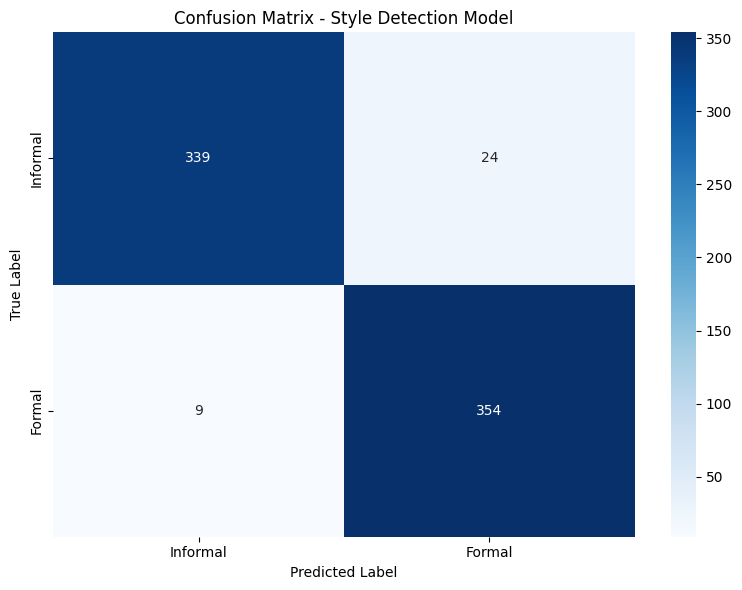


Confusion Matrix (Percentages):
--------------------------------------------------------------------------------
                Predicted Informal   Predicted Formal    
--------------------------------------------------------------------------------
True Informal   93.39                6.61                
True Formal     2.48                 97.52               


In [ ]:
# Confusion Matrix
if eval_dataset:
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Informal', 'Formal'],
        yticklabels=['Informal', 'Formal']
    )
    plt.title('Confusion Matrix - Style Detection Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    print("\nConfusion Matrix (Percentages):")
    print("-" * 80)
    print(f"{'':<15} {'Predicted Informal':<20} {'Predicted Formal':<20}")
    print("-" * 80)
    print(f"{'True Informal':<15} {cm_percent[0,0]:<20.2f} {cm_percent[0,1]:<20.2f}")
    print(f"{'True Formal':<15} {cm_percent[1,0]:<20.2f} {cm_percent[1,1]:<20.2f}")
    print("=" * 80)


## 11. Testing Model dengan Contoh Teks


In [ ]:
# Function to predict style
def predict_style(text, model, tokenizer, device):
    """
    Predict style (informal/formal) for a given text
    """
    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    ).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    label = "Informal" if predicted_class == 0 else "Formal"

    return {
        'text': text,
        'predicted_label': label,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'probabilities': {
            'Informal': predictions[0][0].item(),
            'Formal': predictions[0][1].item()
        }
    }

# Test with sample texts
test_texts = [
    "gmn sih loe, ngakak bgt 😂",  # Informal
    "bagaimana sih kamu, sangat lucu",  # Formal
    "min tolong dong kenapaa paket xxxnumberxxx xxxnumberxxx gb yang xxxnumberxxx xxxnumberxxx k nya kok hilaang",  # Informal
    "admin, tolong. mengapa paket xxxnumberxxx xxxnumberxxx gb yang xxxnumberxxx ribunya hilang?",  # Formal
    "selamat pagi, admin. saya ingin bertanya mengenai layanan yang tersedia",  # Formal
    "pagi min, mau nanya nih soal layanan",  # Informal
]

print("Testing Model with Sample Texts")
print("=" * 80)

for i, text in enumerate(test_texts, 1):
    result = predict_style(text, model, tokenizer, device)
    print(f"\nTest {i}:")
    print(f"  Text: {result['text']}")
    print(f"  Predicted: {result['predicted_label']} (confidence: {result['confidence']:.4f})")
    print(f"  Probabilities: Informal={result['probabilities']['Informal']:.4f}, Formal={result['probabilities']['Formal']:.4f}")
    print("-" * 80)


Testing Model with Sample Texts

Test 1:
  Text: gmn sih loe, ngakak bgt 😂
  Predicted: Informal (confidence: 0.9998)
  Probabilities: Informal=0.9998, Formal=0.0002
--------------------------------------------------------------------------------

Test 2:
  Text: bagaimana sih kamu, sangat lucu
  Predicted: Informal (confidence: 0.9993)
  Probabilities: Informal=0.9993, Formal=0.0007
--------------------------------------------------------------------------------

Test 3:
  Text: min tolong dong kenapaa paket xxxnumberxxx xxxnumberxxx gb yang xxxnumberxxx xxxnumberxxx k nya kok hilaang
  Predicted: Informal (confidence: 0.9999)
  Probabilities: Informal=0.9999, Formal=0.0001
--------------------------------------------------------------------------------

Test 4:
  Text: admin, tolong. mengapa paket xxxnumberxxx xxxnumberxxx gb yang xxxnumberxxx ribunya hilang?
  Predicted: Formal (confidence: 0.9997)
  Probabilities: Informal=0.0003, Formal=0.9997
-------------------------------------

## 12. Save Model


In [ ]:
# Save model and tokenizer
MODEL_SAVE_PATH = "./style_detection_model_final"

print(f"Saving model to {MODEL_SAVE_PATH}...")

# Save model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model and tokenizer saved successfully to {MODEL_SAVE_PATH}!")

# Verify saved files
if os.path.exists(MODEL_SAVE_PATH):
    files = os.listdir(MODEL_SAVE_PATH)
    print(f"\nSaved files:")
    for file in files:
        file_path = os.path.join(MODEL_SAVE_PATH, file)
        size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
        print(f"  - {file} ({size:.2f} MB)")


Saving model to ./style_detection_model_final...
Model and tokenizer saved successfully to ./style_detection_model_final!

Saved files:
  - vocab.txt (0.22 MB)
  - tokenizer_config.json (0.00 MB)
  - model.safetensors (421.77 MB)
  - special_tokens_map.json (0.00 MB)
  - config.json (0.00 MB)
  - tokenizer.json (0.70 MB)
